<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/WebPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# установка нужных библиотек
!pip install onnxmltools==1.7.0 onnxruntime==1.4.0
!pip install tensorflow==1.14.0
#!pip install tensorflow-gpu==1.14.0

In [ ]:
# импорт библиотек
import tensorflow as tf
from tensorflow.keras import backend as K
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from PIL import Image
import os

os.environ['TF_KERAS'] = '1'
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime

# Предсказание погоды в Москве

In [ ]:
# загрузка датасета с температурой москвы за 50 лет
!gdown --id 1ri2GUfwryJ0OuW7ygKbSmmteOPaUPFSP

Downloading...
From: https://drive.google.com/uc?id=1ri2GUfwryJ0OuW7ygKbSmmteOPaUPFSP
To: /content/dataset.csv
100% 338k/338k [00:00<00:00, 43.0MB/s]


In [ ]:
# чтение из файла
df = pd.read_csv('dataset.csv')
[(col, df[col].isna().sum()) for col in df]

[('Temperature', 0), ('month', 0), ('day', 0), ('temperature_tommorow', 0)]

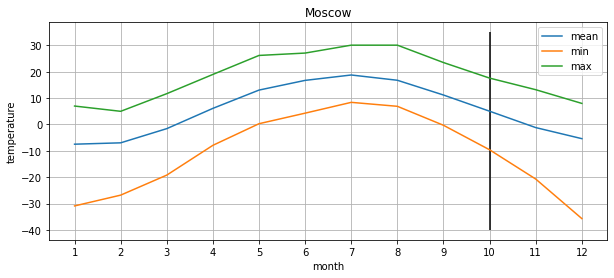

In [ ]:
# визуализация данных
ax = df.groupby('month').\
        Temperature.\
        agg(['mean', 'min', 'max']).\
        plot(figsize=(10, 4))
ax.set_xticks([i for i in range(1, 13)])
ax.set_ylabel('temperature')
ax.set_title('Moscow')
ax.vlines(10, -40, 35)
ax.grid()

In [ ]:
# обучение случайного леса
rfr = RandomForestRegressor(max_depth=10, n_estimators=200, max_features=1,
                            n_jobs=-1, oob_score=True, random_state=0).\
                            fit(df[['Temperature', 'month', 'day']],
                                df.temperature_tommorow)
r2_score(df.Temperature, df.temperature_tommorow), rfr.oob_score_, rfr.feature_importances_

(0.9311772323618567,
 0.9330343961978274,
 array([0.64821636, 0.34445166, 0.00733198]))

In [ ]:
# предсказание
rfr.predict([[12, 10, 7]])

array([9.88984105])

In [ ]:
# конвертация в onnx формат
initial_types = [('float_input', FloatTensorType([None, 3]))] 
onnx_model = onnxmltools.convert_sklearn(rfr, target_opset=9,
                                         initial_types=initial_types)

In [ ]:
# сохранение модели
onnx.checker.check_model(onnx_model)
with open('weather_rfr.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())
# тестовый запуск
sess = onnxruntime.InferenceSession('weather_rfr.onnx')
print([(node.name, node.shape) for node in sess.get_inputs()])
sess.run(None, {'float_input': [[12, 10, 7]]})

[('float_input', [None, 3])]


[array([[9.889841]], dtype=float32)]

# Демо
# https://dlz7i.csb.app
# Код
# https://codesandbox.io/s/sklearnonnxtest-dlz7i

# Выделение каналов изображения


In [ ]:
# вспомогательные веса
r_mul = np.float32([1, 0, 0, 1]).reshape(1, 1, 1, -1)
g_mul = np.float32([0, 1, 0, 1]).reshape(1, 1, 1, -1)
b_mul = np.float32([0, 0, 1, 1]).reshape(1, 1, 1, -1)

# модель keras формата
inp = tf.keras.layers.Input((None, None , 4), name='input') 
R = tf.keras.layers.Lambda(lambda xx: xx*tf.constant(r_mul, dtype=np.float32),
                           name='r')(inp)
G = tf.keras.layers.Lambda(lambda xx: xx*tf.constant(g_mul, dtype=np.float32),
                           name='g')(inp)
B = tf.keras.layers.Lambda(lambda xx: xx*tf.constant(b_mul, dtype=np.float32),
                           name='b')(inp)
model = tf.keras.models.Model(inp, [R, G, B])
model.summary()
model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
r (Lambda)                      (None, None, None, 4 0           input[0][0]                      
__________________________________________________________________________________________________
g (Lambda)                      (None, None, None, 4 0           input[0][0]                      
__________________________________________________________________________________________________
b (Lambda)                      (None, None, None, 4 0           input[0][0]                      
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________

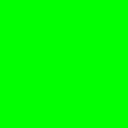

In [ ]:
# тестовая проверка на белой картинке
output = np.uint8(model.predict(255*np.ones((1, 128, 128, 4))))
Image.fromarray(output[1][0][:,:,:3])

In [ ]:
# конвертация модели в onnx
onnx_model = onnxmltools.convert_keras(model, target_opset=9)

The ONNX operator number change on the optimization: 11 -> 3
The maximum opset needed by this model is only 7.


In [ ]:
# сохранение в файл и тестовый запуск
#onnx.checker.check_model(onnx_model)
with open('rgb.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())
sess = onnxruntime.InferenceSession('rgb.onnx')
print([(node.name, node.shape) for node in sess.get_inputs()])
sess.run(None, {'input': np.ones((1, 1, 1, 4), dtype=np.float32)})

[('input', ['N', 'M1', 'M2', 4])]


[array([[[[1., 0., 0., 1.]]]], dtype=float32),
 array([[[[0., 1., 0., 1.]]]], dtype=float32),
 array([[[[0., 0., 1., 1.]]]], dtype=float32)]

# Демо
# https://csb-87b95-6m1b58iet-defasium.vercel.app
# Код
# https://codesandbox.io/s/rgb-87b95